In [1]:
import pandas as pd

In [55]:
DATA = '../data/'


NameError: name 'seaborn' is not defined

In [3]:
summaries_df = pd.read_csv(DATA + 'final_summaries_ai_aloe_fixed.csv')

In [6]:
df = summaries_df.sample(10)
df_col_names = ['Row.names', 'text', 'source']
for i in df.columns[6:12]:
    df_col_names.append(i)
sample_df = df[df_col_names]

In [7]:
sample_df.to_csv('sample_texts.csv')

## Get containment score

In [17]:
!pip install nltk
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk import trigrams, word_tokenize

english_stop_words = stopwords.words('english')

def tokenize_text(text: str):
    return [tok for tok in word_tokenize(text.lower())
            if tok not in english_stop_words]

def get_trigrams(text: str):
    return set(trigrams(tokenize_text(text)))

def containment_score(
    source: str = None, summary: str = None
) -> float:
    '''Calculate containment score between a source text and a derivative text.
    Calculated as the intersection of unique trigrams divided by the number if 
    unique trigrams in the derivative text.
    Values range from 0 to 1, with 1 being completely copied.
    Allows for source and summary to be manually input for testing purposes.'''
    src = get_trigrams(source)
    txt = get_trigrams(summary)
    try:
        containment = len(src.intersection(txt)) / len(txt)
        return round(containment, 4)
    except ZeroDivisionError:
        return 1.0

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [18]:
summaries_df['containment'] = summaries_df.apply(lambda row: containment_score(row['source'], row['text']), axis=1)

Text(0.5, 0, 'Containment Score')

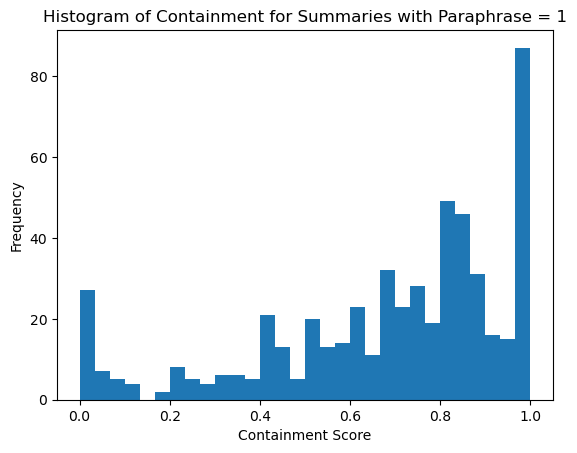

In [26]:
from matplotlib import pyplot as plt
summaries_df[summaries_df['Wording.Para'] == 1]['containment'].plot.hist(bins=30)
plt.title('Histogram of Containment for Summaries with Paraphrase = 1')
plt.xlabel('Containment Score')

Text(0.5, 0, 'Containment Score')

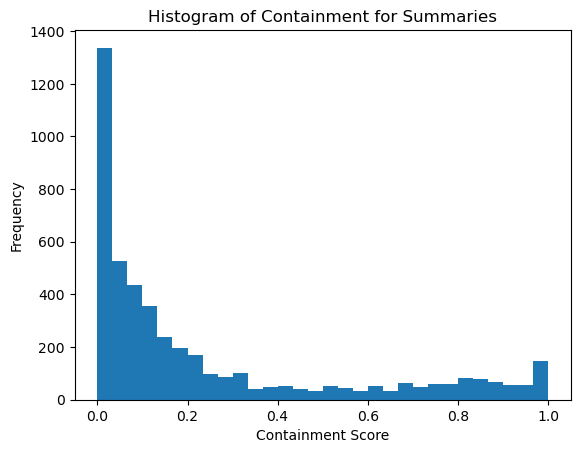

In [42]:
from matplotlib import pyplot as plt
summaries_df['containment'].plot.hist(bins=30)
plt.title('Histogram of Containment for Summaries')
plt.xlabel('Containment Score')

## Similarity Scores

In [29]:
!pip install gensim
from gensim.models import Doc2Vec
from scipy import spatial

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.4/26.4 MB 33.4 MB/s eta 0:00:0000:0100:01


In [33]:
doc2vec_model = Doc2Vec.load('../../../textbook-summary-api/assets/doc2vec_model')

In [34]:
def similarity_score(source, summary) -> float:
    '''Return semantic similarity score based on summary and source text.
    '''
    source_tokens = tokenize_text(source)
    summary_tokens = tokenize_text(summary)
    source_embedding = doc2vec_model.infer_vector(source_tokens)
    summary_embedding = doc2vec_model.infer_vector(summary_tokens)
    return 1 - spatial.distance.cosine(summary_embedding, source_embedding

In [35]:
summaries_df['similarity'] = summaries_df.apply(lambda row: similarity_score(row['source'], row['text']), axis=1)

Text(0.5, 0, 'Similarity Score')

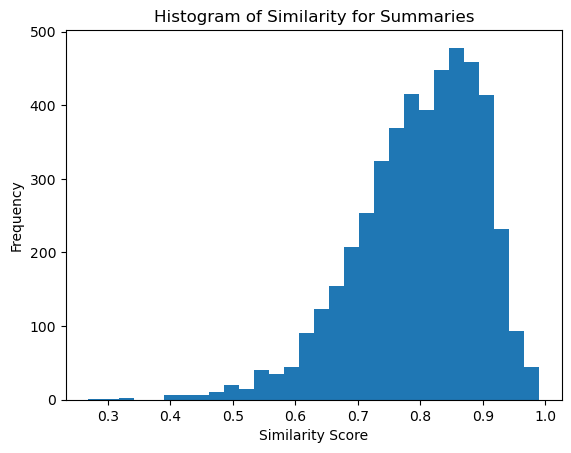

In [46]:
summaries_df['similarity'].plot.hist(bins = 30)
plt.title('Histogram of Similarity for Summaries')
plt.xlabel('Similarity Score')

Text(0.5, 0, 'Similarity Score')

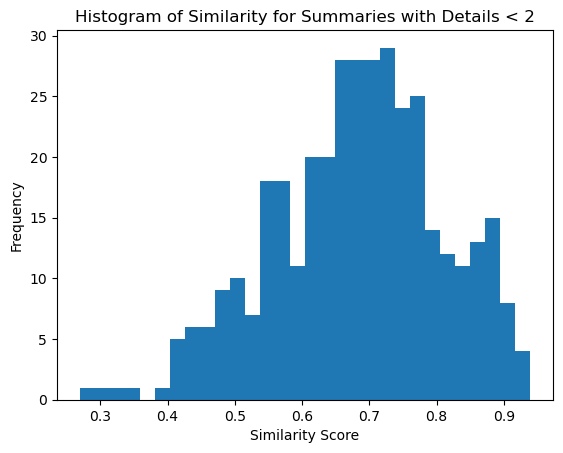

In [45]:
summaries_df[summaries_df['Details'] < 2]['similarity'].plot.hist(bins = 30)
plt.title('Histogram of Similarity for Summaries with Details < 2')
plt.xlabel('Similarity Score')

Text(0.5, 1.0, 'Doc2Vec Similarity Score by Details')

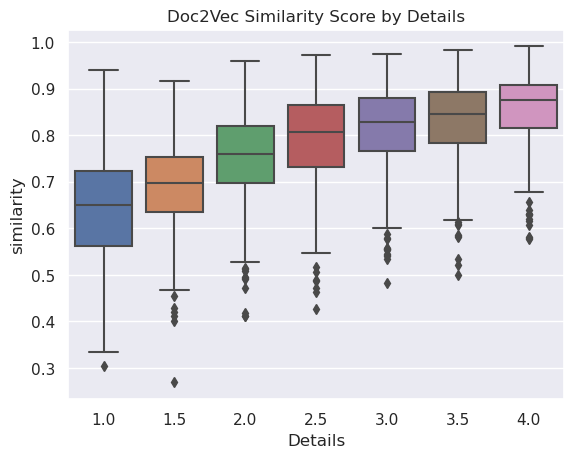

In [57]:
import seaborn as sns
sns.set_theme(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)
sns.boxplot(data=summaries_df[summaries_df['Details'] > 0.5], x='Details', y='similarity')
plt.title('Doc2Vec Similarity Score by Details')

Text(0.5, 0, 'Wording/Paraphrase')

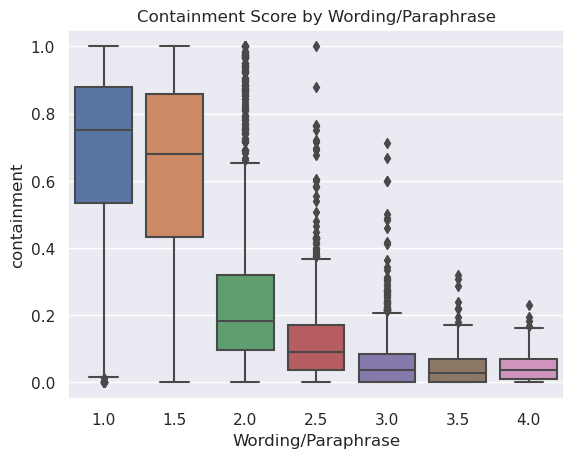

In [59]:
sns.boxplot(data=summaries_df[summaries_df['Wording.Para'] > 0.5], x='Wording.Para', y='containment')
plt.title('Containment Score by Wording/Paraphrase')
plt.xlabel('Wording/Paraphrase')